In [222]:
# Settings for notebook
try:
    import scrapy
except:
    !pip install scrapy
    import scrapy
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

from scrapy.crawler import CrawlerProcess
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider,Rule
from scrapy.exceptions import IgnoreRequest
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from urllib.parse import urlparse
import urllib.request

import unicodedata
import logging
import sys
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import json
import numpy as np
from textblob import TextBlob
%matplotlib inline

In [46]:
from textblob import Word
from nltk import pos_tag
def lemmatization(list_words):
    lemmatized_words = []
    #lemma does not accept pos tags natively - convert to simplified version
    posTb2Wn={'JJ':'a', 'JJR':'a', 'JJS':'a', 'RB':'r', 'RBR':'r', 'RBS':'r', 'VB':'v', 'VBD':'v', 
              'VBG':'v', 'VBN':'v', 'VBP':'v', 'VBZ':'v', 'NN':'n', 'NNS':'n', 'NNP':'n', 'NNPS':'n', 
              'n':'n', 'a':'a', 'r':'r', 'v':'v', 's':'s'}
    for item in list_words:
        item = item.split()
        if len(item)>1:
            lemmatized_phrase =[]
            for word,tag in pos_tag(item):
                lemmatized_phrase.append(Word(word).lemmatize(posTb2Wn.get(tag)))
            lemmatized_words.append(' '.join(lemmatized_phrase))
        else:
            word,tag = pos_tag(item)[0]
            lemmatized_words.append(Word(word).lemmatize(posTb2Wn.get(tag)))
            
    return lemmatized_words
def remove_stopwords(list_words):
    new_list = []
    for word in list_words:
        if word not in list(set(stopwords.words('english'))):
            new_list.append(word)
    return new_list
def lower_case(list_words):
    return [word.lower() for word in list_words]

In [47]:
# read in park amentities
f = open('park_amentity.dat','r')
content = f.readlines()
n = 0
amentity_list= {}
for line in content:
    feature = [item.strip() for item in line.strip('\n').split(',')]
    if feature!=['']:
        feature = lower_case(feature)
        feature = lemmatization(feature)
        amentity_list[n] = feature
        n+=1

In [582]:
# read in park reviews
# df_raw = pd.read_csv('Griggs_review.csv')
park_name = 'Klyde_Park'
review_file = 'tripAdvisor_result_'+ park_name+'.json'
df_raw = pd.read_json(review_file)
# df_raw = pd.read_csv('Griggs_review.csv')
print(df_raw.shape)
df = df_raw.loc[:,['review']]
df.head()

(996, 3)


,review
0,This park is a Dallas Must See! It is amazing ...
1,This is a great thing to do on a beautiful spr...
2,This is a sorry excuse for a park. Built in th...
3,"When this park was first proposed, I poo-poo'd..."
4,We live in the Dallas Metroplex and thought ci...


In [583]:
%%time
tknz = TweetTokenizer()
df_tokenize = df.applymap(lambda x: tknz.tokenize(x))
df_lowercase = df_tokenize.applymap(lambda x: lower_case(x))
df_remove_stopwords = df_lowercase.applymap(lambda x: remove_stopwords(x))
df_lemma = df_remove_stopwords.applymap(lambda x: lemmatization(x))

CPU times: user 48.5 s, sys: 5.21 s, total: 53.7 s
Wall time: 1min 2s


In [584]:
df_review = df.copy()
df_review['lower_case'] = df_lowercase.loc[:,'review'].apply(lambda x: ' '.join(x))
df_review['remove_stop_words'] = df_remove_stopwords.loc[:,'review'].apply(lambda x: ' '.join(x))
df_review['review_clean'] = df_lemma.loc[:,'review'].apply(lambda x: ' '.join(x))
df_review.head()

,review,lower_case,remove_stop_words,review_clean
0,This park is a Dallas Must See! It is amazing ...,this park is a dallas must see ! it is amazing...,park dallas must see ! amazing see traffic goi...,park dallas must see ! amaze see traffic go tu...
1,This is a great thing to do on a beautiful spr...,this is a great thing to do on a beautiful spr...,great thing beautiful spring day . shared park...,great thing beautiful spring day . share park ...
2,This is a sorry excuse for a park. Built in th...,this is a sorry excuse for a park . built in t...,sorry excuse park . built middle town . people...,sorry excuse park . built middle town . people...
3,"When this park was first proposed, I poo-poo'd...","when this park was first proposed , i poo-poo'...","park first proposed , poo-poo'd . boy wrong . ...","park first propose , poo-poo'd . boy wrong . w..."
4,We live in the Dallas Metroplex and thought ci...,we live in the dallas metroplex and thought ci...,live dallas metroplex thought city leaders tot...,live dallas metroplex thought city leader tota...


In [585]:
def find_feature(feature,text):
    feature_sentence = []
    textblob_obj = TextBlob(text)
    for sentence_idx, sentence in enumerate(textblob_obj.sentences):
#         if all(word in sentence.words for word in feature): 
        if (feature in sentence):
            print(str(sentence_idx)+':',sentence)
            if ('not' in sentence):
                print('******NOT******')
            feature_sentence.append(sentence_idx)
    return feature_sentence
def get_feature_opinion(feature,review_series):
    df_op_sen = pd.DataFrame(columns=['opinion_sentence','polarity_score'])
    n =0
    for single_feature in feature:
        print(single_feature)
        df_sen_idx = review_series.apply(lambda x: find_feature(single_feature,x))
        df_sen_idx = [(idx,item) for (idx,item) in enumerate(df_sen_idx) if item]
        # Sentiment analysis of each sentence
        # df_op_sen: dataframe for opinion sentences
        for (review_idx,sen_idx_list) in df_sen_idx:
            review_text = review_series[review_idx]
            for sen_idx in sen_idx_list:
                df_op_sen.loc[n,'opinion_sentence'] = str(TextBlob(review_text).sentences[sen_idx])
                n+=1
#         df_op_sen.to_pickle('trail_sentence')
        df_op_sen['polarity_score']=df_op_sen.loc[:,'opinion_sentence'].apply(
            lambda x: TextBlob(x).sentiment_assessments[0])
        positive = df_op_sen.loc[df_op_sen['polarity_score']>0,'opinion_sentence']
        negative = df_op_sen.loc[df_op_sen['polarity_score']<0,'opinion_sentence']
        neutral  = df_op_sen.loc[df_op_sen['polarity_score']==0,'opinion_sentence']
        print('positive:{0} negative:{1} neutral:{2}'.format(len(positive),len(negative),len(neutral)))
    return len(positive),len(negative),len(neutral)#,positve,negative,netural
            

In [586]:
amentity_opinion = pd.DataFrame(columns=['pos','neg','neu','feature'])
for key in amentity_list.keys():
    print(50*'-')
    feature = amentity_list[key]
    pos,neg,neu = get_feature_opinion(feature,df_review['review_clean']) #(positive,negative,netural)
    amentity_opinion.loc[key,['pos','neg','neu','feature']] = [pos,neg,neu,'/'.join(feature)]
amentity_opinion['total'] =  amentity_opinion['pos'] + amentity_opinion['neg']+amentity_opinion['neu']       

--------------------------------------------------
archery
positive:0 negative:0 neutral:0
--------------------------------------------------
badminton
2: ping pong , badminton , put green , small dog park .
positive:0 negative:1 neutral:0
--------------------------------------------------
baseball
positive:0 negative:0 neutral:0
softball
2: you're expect expansive lush grass big tree play football softball isn't type park doesn't mean people don't try .
positive:0 negative:1 neutral:0
baseball diamond
positive:0 negative:1 neutral:0
softball diamond
positive:0 negative:1 neutral:0
--------------------------------------------------
basketball
positive:0 negative:0 neutral:0
basketball hoop
positive:0 negative:0 neutral:0
--------------------------------------------------
bocce ball
1: go play bocce ball .
positive:0 negative:0 neutral:1
bocce ball court
positive:0 negative:0 neutral:1
bocce
1: go play bocce ball .
positive:0 negative:0 neutral:2
----------------------------------------

5: gravel path along side hang latnerns really nice sight night .
3: soccer field , spacious lawn , walk path , library area stock daily newspaper , large splash park , great children's playground many nook explore .
1: comfortable walk path .
1: seat , walk path , activity take place pavilion , relish restaurant , several food truck available daily visitor , children's play area , easy access via free trolley system .
21: also great place bring lunch , many small mid-sized table chair available along pathway main lawn .
26: , park feel tuilleries paris table chair gravel pathway , much urban feel like central park nyc .
positive:16 negative:6 neutral:2
trail
1: offer walk trail , food truck , friendly people ; architecture tranquility .
2: park many outlet children's area , restaurant , walk trail , event space .
2: playground , walk trail .
15: park , option green space live downtown , reverchon park katy trail ( uptown ) .
positive:18 negative:7 neutral:3
---------------------------

4: dog park even little splash pad dog .
1: lot people , food truck , table , dog park , playground splash park kid .
1: kind food truck , plenty table , splash park kid , playground , dog park , restaurant , nice restroom , large open field , kind free game anyone could play .
1: food truck , dog park , ping pong table , kid play area nice restaurant .
2: food truck available well cute little dog park ( emphasize - little ) .
1: dog park play ground , nice little oasis middle downtown .
0: fun playground area kid ( don't little one play look like fun ) lot table & seat , food truck , ping pong table , dog park .
1: active kiddie dog park water fountain entertain everybody pet .
0: lot place run around - check free - check food option ( food truck abound ) - check free book read - check water sprinkler - check dog park - check check check !
0: glad finally put park center dallas , complete dog park city resident .
3: it's also fun watch dog dog park .
2: nice dog park area .
2: great l

2: food truck , event , dog park , museum may big impact bring people back downtown
2: food truck great diversified across street museum .
10: spot available close pay $ 10 park 2 block away near museum .
3: it's short walk museum downtown activity art district .
1: left museum somewhat disappointed see colorful food truck along road .
3: it's right across dallas museum art , lot great din option close !
2: there's least 2 museum nearby check walk fresh air outside .
0: hit downtown dallas - - niece respite museum ( three across street ) restaurant galore .
0: go downtown visit museum ran across park host first saturday .
13: surround area iso fill lot place visit museum ...
0: unique eclectic " overpass " deck park ... close walk distance dallas museum art ( across street ) east side there's " coffee shop " cafe ... there's outdoor board game stage weekend concert event ...
3: museum take 3 hour .
11: like museum , dinosaur bone , geological rock , outer space .
0: even aren't head ar

1: day go family orient event , lot kid play lawn , music etc .
4: lawn area exercise , lounge , concert , play - check .
2: sit lawn , blanket picnic .
1: free game lawn .
3: soccer field , spacious lawn , walk path , library area stock daily newspaper , large splash park , great children's playground many nook explore .
0: true urban park food truck , restaurant , outdoor activity , outdoor reading room , yoga , skyline view , beautiful lawn , lot dog .
2: there's great span manicure lawn , table chair sit , local food truck line one side sell ware , great restaurant , savor , one side open-air concert stage .
1: choice activity include restaurant , food truck , yoga lush ( sort lush ) lawn lot people watch .
2: lawn & restaurant well kept .
1: three block long green-space middle downtown dallas house active passive space , child ’ park , reading room , great lawn , restaurant , performance pavilion , fountain plaza , game area , urban dog park , botanical garden .
2: food truck , pa

4: playground could big , , wish entire park big .
1: it's great like food truck kid seem like there's nice playground , wouldn't recommend adult want take walk ( unless you're mood short walk walk circle ) .
2: playground little one .
1: food truck line curb everything imagine water feature young kid , book playground .
1: lot people , food truck , table , dog park , playground splash park kid .
2: free reading library craft kid along playground water fountain run .
1: kind food truck , plenty table , splash park kid , playground , dog park , restaurant , nice restroom , large open field , kind free game anyone could play .
1: couple cafe around , book borrowing / reading area , playground zumba aerobics go .
0: lot see , food truck , nom nom nom ... kid love playground .
1: there playground young kid , grassy area old kid play frisbee ball kid love food truck !
0: fun playground area kid ( don't little one play look like fun ) lot table & seat , food truck , ping pong table , dog par

3: play area child .
positive:120 negative:25 neutral:46
--------------------------------------------------
public art
positive:0 negative:0 neutral:0
--------------------------------------------------
rise garden
positive:0 negative:0 neutral:0
--------------------------------------------------
sculpture garden
7: dallas museum art , nasher sculpture garden well crow museum asian art .
2: walk across street great art museum modern art nasher sculpture garden .
1: jump trolley d-link grab bite foodtrucks one restaurant around park , visit dallas museum art , nasher sculpture garden take short walk perot museum street .
1: nice walk park go across street enjoy dallas museum art ( free admission ) , want add another park experience , nasser sculpture garden next door .
******NOT******
0: great space locate near dallas museum art , nasher sculpture garden downtown dallas .
0: beautiful park near museum nash sculpture garden .
6: course dallas museum art , free , nasher sculpture garden , 

14: parking $ 5.00 - $ 10.00 .
0: beautiful park drive around 1/2 hour find parking ❗ ️ 🙀 .
1: get packed around lunch time day parking hit miss .
3: won't visit - worth try find parking place .
7: con : difficult find parking .
3: con : * parking .
4: parking cost pretty penny .
2: pay parking expensive .
3: parking pain , though .
0: take awhile get park ( via free trolley ) free parking , park option play .
6: also parking lot public transit stop nearby .
3: parking little challenge find though .
5: get side street parking meter won't cost near much .
3: however , find parking close stressful challenge .
1: start parking nearby dallas museum art ' parking garage , tour museum , spent rest morning / early afternoon park .
5: parking challenge since thing free parking dallas .
2: street parking available meter .
1: plenty parking nearby .
2: weekend mob scene , still fun ( except parking , scarce surround street $ 10 lot . )
3: complaint would parking , that's pretty much major city .

0: pleasure go park allows give driver's license check board game play croquet , ping pong many old game !
5: secure play area kiddo driver's license id borrow board game book , even ping pong .
positive:1 negative:1 neutral:3
--------------------------------------------------
lake
0: beyond white rock lake dallas always lack place gather outdoors like say central park hyde park klyde warren tiny compare maybe doesn't really compare first truly urban open space - plus surround art district uptown eatery become wonderful destination it's part large day experience cultural aspect dallas .
0: go park area cancel lake plan due weather .
positive:1 negative:1 neutral:0
pond
3: splash pond / fountain kid play saw many take advantage hot dallas summer day .
positive:2 negative:1 neutral:0
reservoir
positive:2 negative:1 neutral:0
--------------------------------------------------
natural area
positive:0 negative:0 neutral:0
manage habitat
positive:0 negative:0 neutral:0
preserve
positive:0 ne

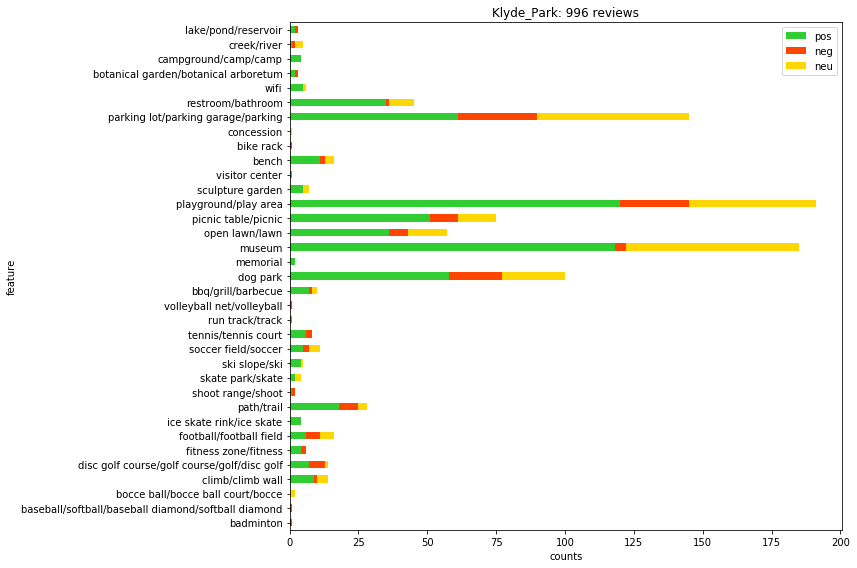

In [587]:
import matplotlib.pyplot as plt
detected_amentity = amentity_opinion.loc[amentity_opinion['total']>0,:]
detected_amentity.set_index('feature',inplace=True)
detected_amentity.loc[:,['pos','neg','neu']].plot.barh(stacked=True,rot=0,color=['limegreen','orangered','gold'],figsize=(12,8));
plt.xlabel('counts')
plt.title(park_name+': {0} reviews'.format(df_review.shape[0]))
plt.tight_layout()
plt.savefig(park_name+'.eps', format='eps', dpi=1000)

In [378]:
df6 = pd.read_csv('/Users/ZhengLi/SMU_OneDrive/OneDrive - Southern Methodist University/SMU/2018Spring/Information retrieval and Web Search/HW5/data_4.csv')

In [379]:
df6['words'] = df6['text'].apply(lambda x: len(x.split()))
df6['avgword_length'] = df6['text'].apply(lambda x: len(x)/len(x.split()))
df6

,docID,text,words,avgword_length
0,1,hot chocolate cocoa beans,4,6.250000
1,2,cocoa south america,3,6.333333
2,3,beans harvest south,3,6.333333
3,4,cocoa butter,2,6.000000
4,5,butter truffles,2,7.500000
5,6,sweet chocolate,2,7.500000
6,7,sweet sugar,2,5.500000
7,8,sugar cane brazil,3,5.666667
8,9,sweet sugar beet,3,5.333333
9,10,sweet cake icing,3,5.333333


In [380]:
from sklearn.cluster import k_means
X =df6.loc[:,['words','avgword_length']]
centroid, label, inertia, n_iter = k_means(X,n_clusters=2,random_state=1,return_n_iter=True)
print(label)
print('Number of iteration is:',n_iter)

[1 1 1 1 0 0 1 1 1 1 1]
Number of iteration is: 1


In [385]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
n_samples = 2000
n_features = 1000
n_topics = 10

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                            remove=('headers','footers','quotes'))


In [563]:
# data_samples = dataset.data[:n_samples]
data_samples =pd.read_pickle('trail_sentence')
n_features = 100
n_topics = 5
data_samples =list(data_samples['opinion_sentence'].values)
n_samples = len(data_samples)

In [564]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_vectorizer  = CountVectorizer(max_df =0.95,min_df=2,max_features=5,stop_words = 'english')
tf =  tf_vectorizer.fit_transform(data_samples)
lda = LatentDirichletAllocation(n_topics = n_topics,max_iter = 5,
                               learning_method = 'online',learning_offset = 50.,
                               random_state=0)
lda.fit(tf)

/Users/ZhengLi/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=5, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [565]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [566]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_topics)


Topics in LDA model:
Topic #0: lake pretty trail path walk
Topic #1: trail path lake walk pretty
Topic #2: trail walk lake path pretty
Topic #3: path pretty trail lake walk
Topic #4: path lake walk pretty trail



In [523]:
model = lda
model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

array([[ 0.23021901,  0.19116992,  0.2427974 ,  0.14069891,  0.19511476],
       [ 0.16391477,  0.26904357,  0.1458997 ,  0.29635301,  0.12478895],
       [ 0.31971755,  0.1557802 ,  0.05250489,  0.26270373,  0.20929363],
       [ 0.13236934,  0.18801692,  0.39293632,  0.14868277,  0.13799465],
       [ 0.22594394,  0.22536144,  0.18180755,  0.17525249,  0.19163458],
       [ 0.19369714,  0.17250014,  0.21185433,  0.1852968 ,  0.23665158],
       [ 0.19944706,  0.22133598,  0.18813315,  0.20622611,  0.18485771],
       [ 0.11453816,  0.11416924,  0.23701581,  0.41373762,  0.12053916]])

In [525]:
tf_feature_names

['dog', 'dogs', 'nice', 'park', 'space']